# Flare Detectability

- [Minimum Detectable Energy](#Minimum-Detectable-Energy)
  - [Method and Example](#eng_ex)
  - [Long Cadence](#lc_en)
-  [Minimum Detectable Peak Flux](#Minimum-Detectable-Peak-Flux)
  - [Method and Example](#pf_ex)
  - [Long Cadence](#lc_pf)
- [Visualizing Detectability on Individual Stars](#Visualizing-Detectability-on-Individual-Stars)
  - [Long Cadence](#lc_viz)

In [1]:
import sys
import numpy as np

from astropy.table import Table, Column
from astropy import units as u

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../src')

import arhap

import energy
import injection

## Minimum Detectable Energy

### Method and Example <a id='eng_ex'></a>

In [2]:
lc_info_table = Table.read("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv")
recovered_injflare_table = Table.read("../data_tables/recovered_injected_flares_longcad.ecsv",format="ascii.ecsv")

In [3]:
kid = 9529322
kep_obj = lc_info_table[lc_info_table["KID"]==kid][0]
lc_table = Table.read(kep_obj['injected_path'], format="ascii.ecsv")

rec_flare_table = recovered_injflare_table[(recovered_injflare_table["true_recovery"])&
                                           (recovered_injflare_table["kid"] == kep_obj["KID"])]
inj_flare_table = Table.read(kep_obj['synth_flare_path'], format="ascii.ecsv")

Here we calculate the percent of flares recovered above E for E from $10^{32}-10^{37}$ ergs. That is:

$$P(E_0) = \frac{\sum N(E_{rec}>E_0)}{\sum N(E_{inj}>E_0)}$$

We then choose a threshold and say the energy of the nearsest P(E) to that threshold is the minimum detectable energy.

In [4]:
e_arr = 10**np.linspace(31, 37, 50)
n_gt_e = np.array([energy.percent_recovery_above_E(rec_flare_table, inj_flare_table, x) for x in e_arr])

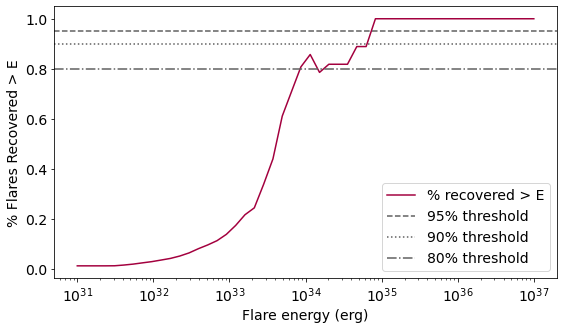

In [5]:
f, ax = plt.subplots(figsize=(9, 5))
ax.tick_params(axis='both', labelsize=14)

ax.plot(e_arr, n_gt_e, c='#a3003e', label="% recovered > E")

ax.axhline(0.95, color="#5e5e5e", linestyle="--", label="95% threshold")
ax.axhline(0.9, color="#5e5e5e", linestyle=":", label="90% threshold")
ax.axhline(0.8, color="#5e5e5e", linestyle="-.", label="80% threshold")

ax.set_xlabel("Flare energy (erg)", fontsize=14)
ax.set_ylabel("% Flares Recovered > E", fontsize=14)
ax.legend(fontsize=14)

ax.semilogx()

plt.show()

In [6]:
min_det_eng = e_arr[arhap.find_nearest(np.array(n_gt_e), 0.8)]
print(f"Minimum detectable energy: {min_det_eng:.3} erg")

Minimum detectable energy: 8.69e+33 erg


In [7]:
print(f"Percent of recovered flares below the minimum detectable energy: {sum(rec_flare_table['E'] < min_det_eng)/len(rec_flare_table):.0%}")

Percent of recovered flares below the minimum detectable energy: 22%


### Long Cadence <a id='lc_eng'></a>

**Note:** This step takes a few minutes.

In [9]:
lc_info_table = Table.read("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv")
lc_info_table.add_column(Column(name="min_det_eng", dtype=float, data=[np.nan]*len(lc_info_table)))

recovered_injflare_table = Table.read("../data_tables/recovered_injected_flares_longcad.ecsv",format="ascii.ecsv")

In [10]:
energy_arr = 10**np.linspace(31, 37, 50)
percent_thresh = 0.95 # 95% threshold

for row in lc_info_table:
    
    rec_flare_table = recovered_injflare_table[(recovered_injflare_table["true_recovery"])&
                                               (recovered_injflare_table["kid"] == row["KID"])]
    if len(rec_flare_table) == 0:
        continue # no recovered flares, can't proceed
    
    inj_flare_table = Table.read(row['synth_flare_path'], format="ascii.ecsv")
    
    n_gt_e = np.array([energy.percent_recovery_above_E(rec_flare_table, inj_flare_table, x) for x in energy_arr])
    
    row["min_det_eng"] = energy_arr[arhap.find_nearest(np.array(n_gt_e), percent_thresh)]

In [11]:
lc_info_table.write("../data_tables/kepler_longcad_info.ecsv",format="ascii.ecsv", overwrite=True)

## Minimum Detectable Peak Flux 

### Method and Example <a id='pf_ex'></a>

In order to compare the recovered and injected peak flux we need to get a peak flux measure in Kepler flux (e-/s). Then our method is the same as for the minimum detectable energy.

In [12]:
kid = 9529322
kep_obj = lc_info_table[lc_info_table["KID"]==kid][0]
lc_table = Table.read(kep_obj['injected_path'], format="ascii.ecsv")

In [13]:
rec_flare_table = recovered_injflare_table[(recovered_injflare_table["true_recovery"])&
                                           (recovered_injflare_table["kid"] == kep_obj["KID"])]

rec_flare_table.add_column(Column(name="inj_peak_kep_flux", dtype=float, length=len(rec_flare_table), unit="e-/s"))

for row in rec_flare_table:
    t_peak = row["inj_flare_t_peak"]
    f_peak = row["inj_f_peak"]
    t_12 = row["inj_t_12"]*u.minute
    
    if f_peak == 0:  # no injected flare
        continue

    flare_fluence = injection.make_fluence_function(f_peak, t_12, t_peak)
        
    flare_ind = arhap.find_nearest(lc_table["time"].jd, t_peak.jd)
    kep_peak = flare_fluence(lc_table["time"][flare_ind]-arhap.Kepler_lc_exptime/2, 
                             lc_table["time"][flare_ind]+arhap.Kepler_lc_exptime/2)/(arhap.Kepler_lc_exptime)
        
    row["inj_peak_kep_flux"] = kep_peak.value

In [14]:
peak_fls = lc_table[rec_flare_table["peak_ind"]]["flux"]
qui_fls = energy.line_func(lc_table[rec_flare_table["peak_ind"]]["time"].jd, 
                           rec_flare_table["qui_m"], rec_flare_table["qui_b"])
    
rec_flare_table["peak_kep_flux"] = peak_fls - qui_fls

In [16]:
inj_flare_table = Table.read(kep_obj['synth_flare_path'], format="ascii.ecsv")
inj_flare_table.add_column(Column(name="f_peak_kep", dtype=float, length=len(inj_flare_table), unit="e-/s"))

for row in inj_flare_table:
    t_peak = row["t_peak"]
    f_peak = row["f_peak"]
    t_12 = row["t_12"]*u.minute
    
    flare_fluence = injection.make_fluence_function(f_peak, t_12, t_peak)
        
    flare_ind = arhap.find_nearest(lc_table["time"].jd, t_peak.jd)
    kep_peak = flare_fluence(lc_table["time"][flare_ind]-arhap.Kepler_lc_exptime/2, 
                             lc_table["time"][flare_ind]+arhap.Kepler_lc_exptime/2)/(arhap.Kepler_lc_exptime)
        
    row["f_peak_kep"] = kep_peak.value

In [17]:
p_arr = 10**np.linspace(0, 7, 50)
n_gt_p = np.array([energy.percent_recovery_above_P(rec_flare_table, inj_flare_table, x) for x in p_arr])

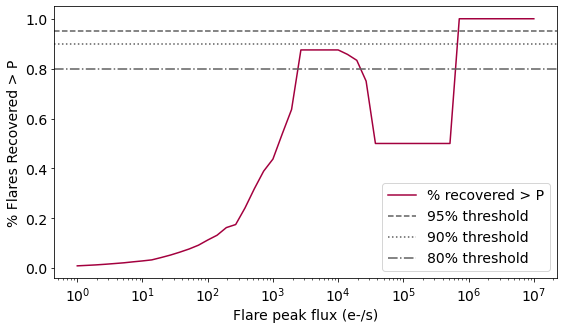

In [18]:
f, ax = plt.subplots(figsize=(9, 5))
ax.tick_params(axis='both', labelsize=14)

ax.plot(p_arr, n_gt_e, c='#a3003e', label="% recovered > P")

ax.axhline(0.95, color="#5e5e5e", linestyle="--", label="95% threshold")
ax.axhline(0.9, color="#5e5e5e", linestyle=":", label="90% threshold")
ax.axhline(0.8, color="#5e5e5e", linestyle="-.", label="80% threshold")

ax.set_xlabel("Flare peak flux (e-/s)", fontsize=14)
ax.set_ylabel("% Flares Recovered > P", fontsize=14)
ax.legend(fontsize=14)

ax.semilogx()

plt.show()

In [19]:
min_det_flux = p_arr[arhap.find_nearest(np.array(n_gt_p), 0.9)]
print(f"Minimum detectable peak flux: {min_det_flux:.4} e-/s")

Minimum detectable peak flux: 372.8 e-/s


### Long Cadence <a id='lc_pf'></a>

**Note:** This step will take some time (~30min-1.5hr)

In [21]:
lc_info_table = Table.read("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv")
lc_info_table.add_column(Column(name="min_det_peak_flux", dtype=float, data=[np.nan]*len(lc_info_table)))

In [22]:
recovered_injflare_table = Table.read("../data_tables/recovered_injected_flares_longcad.ecsv", format="ascii.ecsv")
recovered_injflare_table.add_column(Column(name="peak_kep_flux",
                                           dtype=float, length=len(recovered_injflare_table), unit="e-/s"))
recovered_injflare_table.add_column(Column(name="inj_peak_kep_flux", dtype=float, 
                                           length=len(recovered_injflare_table), unit="e-/s"))

In [25]:
peak_arr = 10**np.linspace(0, 7, 50)
percent_thresh = 0.95 # 95% threshold

for row in lc_info_table:
    lc_table = Table.read(row['injected_path'], format="ascii.ecsv")
    rec_flare_table = recovered_injflare_table[(recovered_injflare_table["true_recovery"])&
                                               (recovered_injflare_table["kid"] == kep_obj["KID"])]
    
    if len(rec_flare_table) == 0:
        continue # no recovered flares, don't need to go further
    
    # We use the indexes into the full flare table because otherwise the changes are
    # limited to our local copy of the single star sub-table
    fl_inds = np.where(recovered_injflare_table["kid"]==row["KID"])[0]
    
    # Calculate the recovered peak flux in kepler units
    peak_fls = lc_table[recovered_injflare_table[fl_inds]["peak_ind"]]["flux"]
    qui_fls = energy.line_func(lc_table[recovered_injflare_table[fl_inds]["peak_ind"]]["time"].jd, 
                               recovered_injflare_table[fl_inds]["qui_m"], 
                               recovered_injflare_table[fl_inds]["qui_b"])
    
    recovered_injflare_table["peak_kep_flux"][fl_inds] = peak_fls - qui_fls
    
    # Calculating the injected peak flux in Kepler units
    for idx in fl_inds:
    
        t_peak = recovered_injflare_table["inj_flare_t_peak"][idx]
        f_peak = recovered_injflare_table["inj_f_peak"][idx]
        t_12 = recovered_injflare_table["inj_t_12"][idx]*u.minute
        
        if f_peak == 0:  # no injected flare
            continue

        flare_fluence = injection.make_fluence_function(f_peak, t_12, t_peak)
        
        flare_ind = arhap.find_nearest(lc_table["time"].jd, t_peak.jd)
        kep_peak = flare_fluence(lc_table["time"][flare_ind]-arhap.Kepler_lc_exptime/2, 
                                 lc_table["time"][flare_ind]+arhap.Kepler_lc_exptime/2)/(arhap.Kepler_lc_exptime)
        
        recovered_injflare_table["inj_peak_kep_flux"][idx] = kep_peak.value
  
    # Calculating the peak flux in Kepler units of ALL the injected flares (not just ones recovered)
    # This is the slow step
    inj_flare_table = Table.read(row['synth_flare_path'], format="ascii.ecsv")
    if not "f_peak_kep" in inj_flare_table.colnames:
        inj_flare_table.add_column(Column(name="f_peak_kep", dtype=float, length=len(inj_flare_table), unit="e-/s"))
    
    for flare in inj_flare_table:
        t_peak = flare["t_peak"]
        f_peak = flare["f_peak"]
        t_12 = flare["t_12"]*u.minute
        
        flare_fluence = injection.make_fluence_function(f_peak, t_12, t_peak)
        
        flare_ind = arhap.find_nearest(lc_table["time"].jd, t_peak.jd)
        kep_peak = flare_fluence(lc_table["time"][flare_ind]-arhap.Kepler_lc_exptime/2, 
                                 lc_table["time"][flare_ind]+arhap.Kepler_lc_exptime/2)/(arhap.Kepler_lc_exptime)
        
        flare["f_peak_kep"] = kep_peak.value
        
    inj_flare_table.write(row['synth_flare_path'], format="ascii.ecsv", overwrite=True)
    
    # Calculating the minimum detectable peak flux
    n_gt_p = np.array([energy.percent_recovery_above_P(rec_flare_table, inj_flare_table, x) for x in peak_arr])
    
    row["min_det_peak_flux"] = peak_arr[arhap.find_nearest(np.array(n_gt_p), percent_thresh)]

In [26]:
lc_info_table.write("../data_tables/kepler_longcad_info.ecsv", format="ascii.ecsv", overwrite=True)

recovered_injflare_table.write("../data_tables/recovered_injected_flares_longcad.ecsv",
                               format="ascii.ecsv", overwrite=True)

**Plotting the injected vs recovered peak fluxes**

Colored by the energy thresholds, so we can see that a good energy recovery indicates a good peak recovery in general.

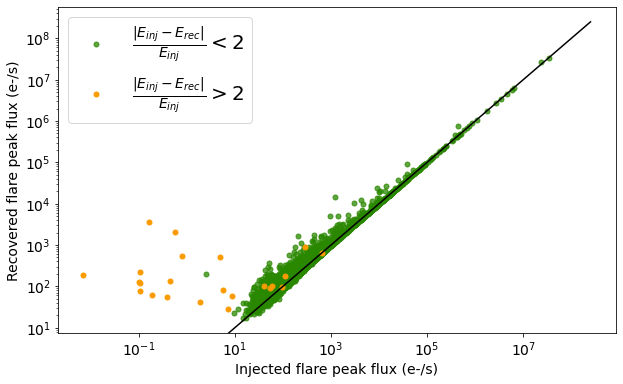

In [3]:
f, ax = plt.subplots(figsize=(10, 6))
ax.tick_params(axis='both', labelsize=14)

ginds = recovered_injflare_table["true_recovery"]
suspects = recovered_injflare_table["suspect"] | recovered_injflare_table["existing_flare"]
ax.plot(recovered_injflare_table['inj_peak_kep_flux'][ginds], recovered_injflare_table["peak_kep_flux"][ginds], 
        '.', alpha=0.75, color="#298700", ms=10 , label="$\\frac{|E_{inj}-E_{rec}|}{E_{inj}} < 2$")
ax.plot(recovered_injflare_table['inj_peak_kep_flux'][~ginds & ~suspects], 
        recovered_injflare_table["peak_kep_flux"][~ginds & ~suspects], 
        '.', ms=10, alpha=1, color="#fa9c00", label="$\\frac{|E_{inj}-E_{rec}|}{E_{inj}} > 2$")

minval,maxval = np.min(recovered_injflare_table['inj_f_peak']), np.max(recovered_injflare_table['inj_f_peak'])
ax.plot([minval,maxval],[minval,maxval], color='black')
ax.loglog()

ax.set_xlabel("Injected flare peak flux (e-/s)", fontsize=14)
ax.set_ylabel("Recovered flare peak flux (e-/s)", fontsize=14)
ax.legend(fontsize=20)

f.savefig("../plots/recoveredVsInjectedPeakFlux.pdf")

plt.show()

## Visualizing Detectability on Individual Stars


### Long Cadence <a id='lc_viz'></a>

We take a star that has a number of observed GALEX flares with a variety of energies, and compating them to the calculated detectability limits.

We do this by creating peak flux vs flare duration contours for the GALEX flare energies and the Kepler minimum detectable energy.

In [2]:
lc_info_table = Table.read("../data_tables/kepler_longcad_info.ecsv",format="ascii.ecsv")
galex_flares = Table.read("../data_tables/galex_flare_stats.ecsv", format="ascii.ecsv")

In [7]:
kid = 9775956
    
kep_obj = lc_info_table[lc_info_table["KID"] == kid][0]
fqui = arhap.kepler_mag_to_count(kep_obj["Kep_Mag"])

lc_table = Table.read(kep_obj['path'], format="ascii.ecsv")
mean_err = lc_table['flux_err'].mean()

g_flares = galex_flares[galex_flares["KID"] == kid]

In [8]:
# Making the minimum detectable energy contour
fpeak_min = kep_obj["min_det_peak_flux"]/fqui.value
t_12_list = np.exp(np.linspace(0.01, 10, 200))*u.second

emin_durs, emin_peaks = injection.make_flare_contour(t_12_list, kep_obj['min_det_eng'], 
                                                     kep_obj["r_est"], mean_err, fqui)

/home/ceb/miniconda3/envs/flares/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [9]:
# making the galex flare contours
f_peak_lists = []
duration_lists = []

for E in g_flares["Ebol"]*0.106:
    durs, peaks = injection.make_flare_contour(t_12_list, E, kep_obj["r_est"], mean_err, fqui)
    f_peak_lists.append(peaks[durs>0])
    duration_lists.append(durs[durs>0])

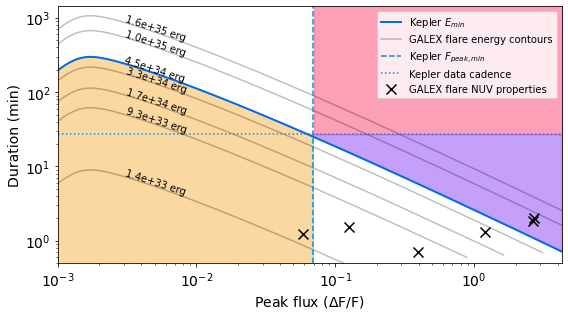

In [10]:
f, ax = plt.subplots(figsize=(8, 4.5))

# top right
peak_gt_min = (emin_peaks >= kep_obj["min_det_peak_flux"]/fqui.value)
bot = np.maximum(emin_durs[peak_gt_min], (arhap.Kepler_lc_exptime).to(u.min).value)
ax.fill_between(emin_peaks[peak_gt_min], bot, [10**4]*len(emin_peaks[peak_gt_min]), 
                color='#f94371', alpha=0.5)

# Bottom left
peak_lt_min = (emin_peaks <= kep_obj["min_det_peak_flux"]/fqui.value+.001 )
ax.fill_between(emin_peaks[peak_lt_min], [0]*len(emin_durs[peak_lt_min]), emin_durs[peak_lt_min], 
                color='#f9b343', alpha=0.5)

# Bottom right
gf_reg = emin_durs < (arhap.Kepler_lc_exptime).to(u.min).value
ax.fill_between(emin_peaks[gf_reg], emin_durs[gf_reg], (arhap.Kepler_lc_exptime).to(u.min).value, 
                color='#8c43f9', alpha=0.5)

ax.plot(emin_peaks, emin_durs, label="Kepler $E_{min}$", color="#006ce5", lw=2)
ax.text(emin_peaks[135], emin_durs[135], f"{kep_obj['min_det_eng']:.1e} erg\n", size=10, va='center', ha="center", 
        rotation=-18, linespacing=.8)

for p_list, d_list, e_val in zip(f_peak_lists, duration_lists, g_flares["Ebol"]*0.106):
    ax.plot(p_list, d_list, color="black", alpha=.25, label="GALEX flare energy contours")
    ind = arhap.find_nearest(p_list, .005)
    ax.text(p_list[ind], d_list[ind], f"{e_val:.1e} erg\n", size=10, va='center', ha="center", 
            rotation=-18, linespacing=.8)
    
ax.axvline(kep_obj["min_det_peak_flux"]/fqui.value, color="#0091e5", linestyle="--", label="Kepler $F_{peak,min}$")
ax.axhline((arhap.Kepler_lc_exptime).to(u.min).value, color="#0091e5", linestyle=":", label="Kepler data cadence")

for gf in g_flares:
    ax.scatter((gf["Peak Flux"]-gf['Qui Flux'])/gf['Qui Flux']/arhap.Kepler_lc_exptime.value*10, 
                gf["Duration"]/60, marker='x',s=100, color='black', label="GALEX flare NUV properties")

arhap.deduped_legend(ax)
ax.loglog()

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel("Peak flux ($\Delta$F/F)", fontsize=14)
ax.set_ylabel("Duration (min)", fontsize=14)

ax.set_xlim(0.001, emin_peaks.max().value)
ax.set_ylim(0.5, 1425)

plt.tight_layout()

#f.savefig("../plots/galex_kep_contour.pdf")

plt.show()